In [96]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import scipy.stats as stats
import numpy as np


### Read in each year and change the name of the Data_Value column to the name of the year and what it represents

In [97]:

data_frames = []
for num in range(2013, 2019):
    df = pd.read_csv(f'../data/heart_dis_{num}.csv')
    df[f'{num}_mort_per_100k'] = df['Data_Value']
    if num != 2013:
        data_frames.append(df[[f'{num}_mort_per_100k', 
                               'LocationID', 'Stratification1', 'Stratification2', 'GeographicLevel']])
    else:
        data_frames.append(df)

### Remove unwanted rows 

In [98]:
cleaned = []
for df in data_frames:
    temp = df[(df['Stratification1'] == 'Overall') 
              & (df['Stratification2'] == 'Overall') 
              & (df['GeographicLevel'] == 'County')]
    temp = temp.drop(columns=['Stratification1', 'Stratification2', 'GeographicLevel'])
    cleaned.append(temp)

### Merging all years on the key of 'LocationDesc'

In [99]:
data_set = pd.merge(cleaned[0], cleaned[1], on='LocationID', how='inner')
data_set = pd.merge(data_set, cleaned[2], on='LocationID', how='inner')
data_set = pd.merge(data_set, cleaned[3], on='LocationID', how='inner')
data_set = pd.merge(data_set, cleaned[4], on='LocationID', how='inner')
data_set = pd.merge(data_set, cleaned[5], on='LocationID', how='inner')

data_set.head()

,Year,LocationAbbr,LocationDesc,DataSource,Class,Topic,Data_Value,Data_Value_Unit,Data_Value_Type,Data_Value_Footnote_Symbol,...,StratificationCategory2,TopicID,LocationID,Location,2013_mort_per_100k,2014_mort_per_100k,2015_mort_per_100k,2016_mort_per_100k,2017_mort_per_100k,2018_mort_per_100k
0,2013,AK,Aleutians East,NVSS,Cardiovascular Diseases,Heart Disease Mortality,147.4,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,Race/Ethnicity,T2,2013,"(55.440626, -161.962562)",147.4,105.3,110.1,68.6,172.9,155.2
1,2013,AK,Aleutians West,NVSS,Cardiovascular Diseases,Heart Disease Mortality,229.4,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,Race/Ethnicity,T2,2016,"(52.995403, -170.251538)",229.4,211.9,172.8,259.8,172.2,174.2
2,2013,AK,Anchorage,NVSS,Cardiovascular Diseases,Heart Disease Mortality,255.5,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,Race/Ethnicity,T2,2020,"(61.159049, -149.103905)",255.5,257.9,259.3,252.1,243.3,249.3
3,2013,AK,Bethel,NVSS,Cardiovascular Diseases,Heart Disease Mortality,305.5,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,Race/Ethnicity,T2,2050,"(60.924483, -159.749655)",305.5,351.6,319.2,345.7,337.1,349.8
4,2013,AK,Bristol Bay,NVSS,Cardiovascular Diseases,Heart Disease Mortality,NaN,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",~,...,Race/Ethnicity,T2,2060,"(58.754192, -156.694709)",NaN,NaN,NaN,NaN,NaN,NaN


### Removing any rows that are missing data

In [100]:
data_set = data_set.dropna(subset=['2013_mort_per_100k', '2014_mort_per_100k', 
                        '2015_mort_per_100k', '2016_mort_per_100k',
                       '2017_mort_per_100k', '2018_mort_per_100k'])

### A quick plot to determine if the mortalities follow a normal distribution

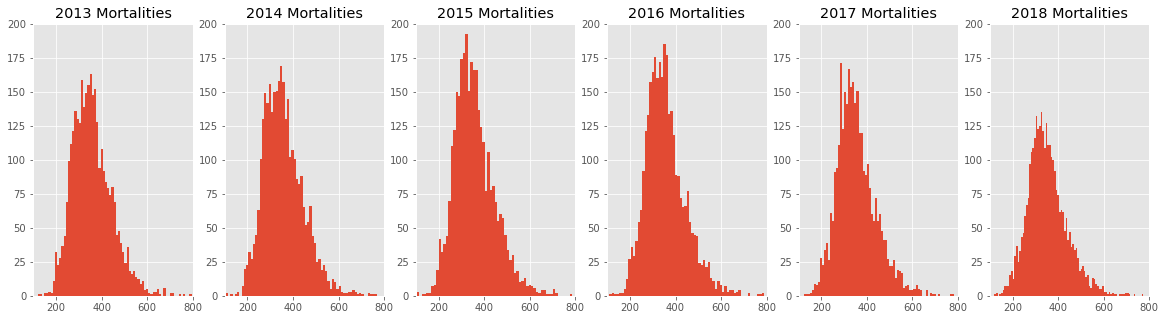

In [101]:
fig, axs = plt.subplots(1,6, figsize=(20,5))
for i in range(6):
    axs[i].hist(data_set[f'{2013+i}_mort_per_100k'], bins=100)
    axs[i].set_xlim(100,800)
    axs[i].set_ylim(0,200)
    axs[i].set_title(f'{2013+i} Mortalities');

### Another plot to see if the values change over time

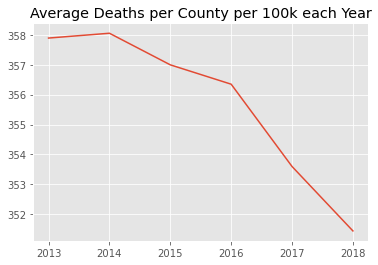

In [102]:
y = []
for i in range(6):
    y.append(data_set[f'{2013+i}_mort_per_100k'].mean())
x = [2013, 2014, 2015, 2016, 2017, 2018]
fig, ax = plt.subplots()
ax.plot(x,y)
ax.set_title('Average Deaths per County per 100k each Year');


## Now that the dataset is in a workable format let's start loading in features to compare it to
### Load in temperature data and strip the word county from location column. Here we also throw out columns we dont need

In [103]:
temps = []
for i in range(2013, 2019):
    temperature = pd.read_csv(f'../data/temperature/{i}_temp.csv', sep=",", engine='python')
    temperature['LocationDesc'] = temperature['Location'].str.rstrip('County')
    temperature['LocationDesc'] = temperature['LocationDesc'].str.rstrip(' ')
    temperature['LocationAbbr'] = temperature['Location ID'].str[:2]
    temperature = temperature.rename(columns={"Value": f'{i}_average_temp'})
    temperature = temperature.drop(['Rank', 'Anomaly (1901-2000 base period)', '1901-2000 Mean', 'Location'], axis=1)                            
    temps.append(temperature)

### In order to merge the temperature data with the heart disease data we need to clean the word 'county' off of the 'LocationDesc' column

In [104]:
data_set['LocationDesc'] = data_set['LocationDesc'].str.rstrip('County')
data_set['LocationDesc'] = data_set['LocationDesc'].str.rstrip(' ')

# The two dataframes are now merged on the LocationDesc and LoacationAbbr attributes. We have to use both
# since there are counties in different states with the same names
for df in temps:
     data_set = pd.merge(data_set, df, on=['LocationDesc', 'LocationAbbr'], how='inner')
   

data_set.head()

,Year,LocationAbbr,LocationDesc,DataSource,Class,Topic,Data_Value,Data_Value_Unit,Data_Value_Type,Data_Value_Footnote_Symbol,...,Location ID_y,2014_average_temp,Location ID_x,2015_average_temp,Location ID_y,2016_average_temp,Location ID_x,2017_average_temp,Location ID_y,2018_average_temp
0,2013,AL,Blount,NVSS,Cardiovascular Diseases,Heart Disease Mortality,385.8,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,AL-009,59.3,AL-009,60.5,AL-009,62.4,AL-009,64.6,AL-009,62.0
1,2013,AL,Autauga,NVSS,Cardiovascular Diseases,Heart Disease Mortality,445.2,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,AL-001,62.4,AL-001,63.5,AL-001,65.7,AL-001,66.9,AL-001,64.7
2,2013,AL,Baldwin,NVSS,Cardiovascular Diseases,Heart Disease Mortality,376.1,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,AL-003,65.7,AL-003,66.2,AL-003,68.6,AL-003,69.7,AL-003,67.9
3,2013,AL,Barbour,NVSS,Cardiovascular Diseases,Heart Disease Mortality,476.7,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,AL-005,63.4,AL-005,64.3,AL-005,66.4,AL-005,67.7,AL-005,66.0
4,2013,AL,Bibb,NVSS,Cardiovascular Diseases,Heart Disease Mortality,458.9,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,AL-007,61.1,AL-007,62.1,AL-007,63.9,AL-007,65.4,AL-007,63.2


### Normalizing both temperature and the mortality rates so that they can be plotted on the same graph

In [105]:

data_set['2013_norm_deaths'] = (data_set['2013_mort_per_100k']-data_set['2013_mort_per_100k'].min())/(data_set['2013_mort_per_100k'].max()-data_set['2013_mort_per_100k'].min())
data_set['2013_norm_temp'] = (data_set['2013_average_temp']-data_set['2013_average_temp'].min())/(data_set['2013_average_temp'].max()-data_set['2013_average_temp'].min())


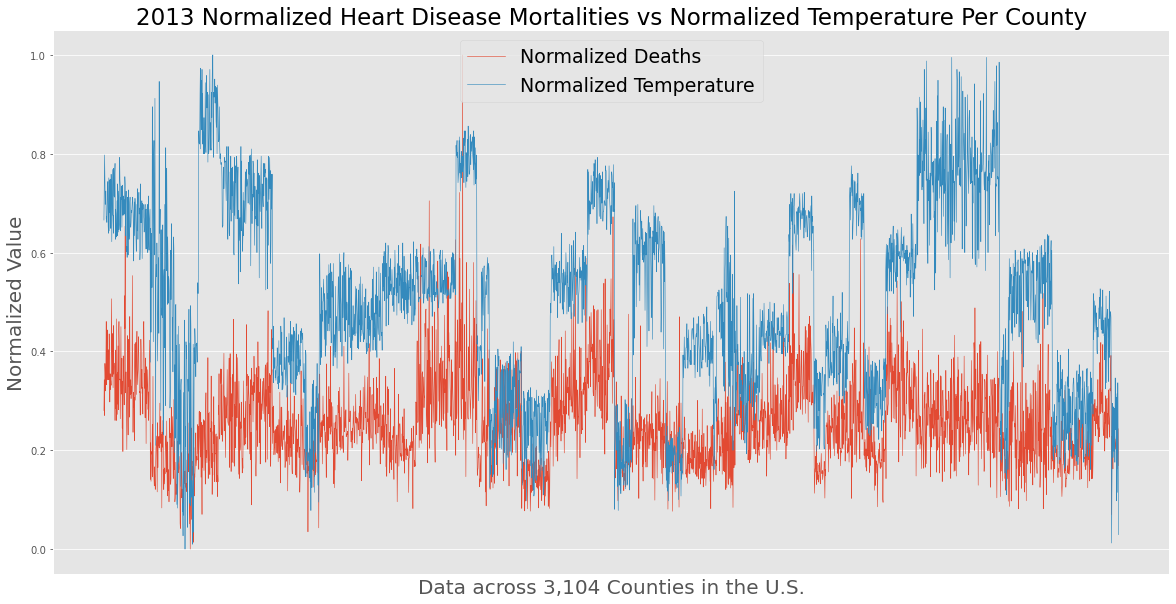

In [106]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_set['2013_norm_deaths'], label='Normalized Deaths', linewidth=.6)
ax.plot(data_set['2013_norm_temp'], label='Normalized Temperature', linewidth=.6)
ax.set_title('2013 Normalized Heart Disease Mortalities vs Normalized Temperature Per County', size=23)
ax.set_xticks([])
ax.set_ylabel('Normalized Value', size=20)
ax.set_xlabel('Data across 3,104 Counties in the U.S.', size=20)
ax.legend(prop={'size': 19})
plt.savefig('../images/normalized_temp_death.jpg', bbox_inches='tight')


### Let's look to see if there is any variation by states by grouping the counties by state and graphing the results

In [107]:
states = data_set.groupby('LocationAbbr').mean()
states = states.reset_index()
states.head()

,LocationAbbr,Year,Data_Value,LocationID,2013_mort_per_100k,2014_mort_per_100k,2015_mort_per_100k,2016_mort_per_100k,2017_mort_per_100k,2018_mort_per_100k,2013_average_temp,2014_average_temp,2015_average_temp,2016_average_temp,2017_average_temp,2018_average_temp,2013_norm_deaths,2013_norm_temp
0,AL,2013.0,466.973134,1067.000000,466.973134,473.443284,470.359701,471.467164,465.728358,462.434328,64.716418,61.304478,62.346269,64.371642,65.934328,63.832836,0.365554,0.700400
1,AR,2013.0,448.858667,5075.000000,448.858667,452.524000,455.125333,459.426667,450.712000,446.986667,63.373333,59.040000,58.920000,61.429333,63.230667,61.708000,0.346546,0.667642
2,AZ,2013.0,291.093333,4013.866667,291.093333,287.786667,288.713333,288.273333,288.693333,283.926667,62.953333,62.566667,63.506667,62.866667,63.626667,64.886667,0.181000,0.657398
3,CA,2013.0,304.968966,6058.000000,304.968966,303.001724,297.774138,299.700000,292.243103,287.056897,57.715517,58.805172,60.191379,59.415517,58.663793,59.555172,0.195560,0.529647
4,CO,2013.0,251.106250,8062.234375,251.106250,250.067188,252.764062,250.128125,246.039063,240.192187,46.942188,44.596875,45.501563,46.357813,46.514062,47.565625,0.139041,0.266883


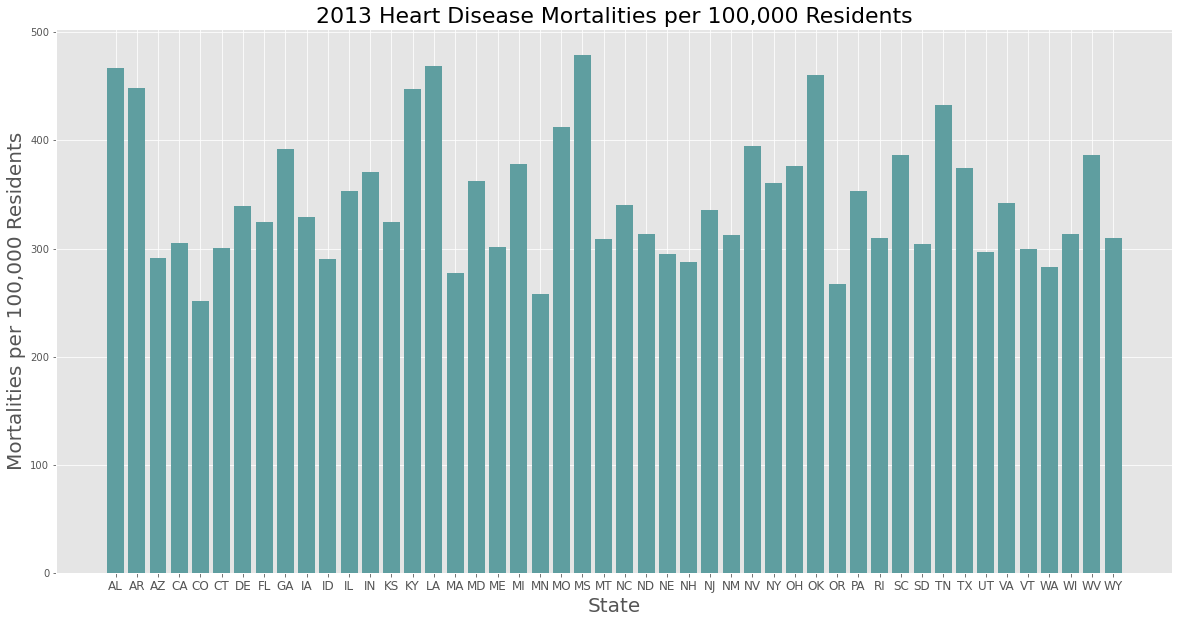

In [108]:
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(0, 48):
    ax.bar(states.loc[i, 'LocationAbbr'], states.loc[i, '2013_mort_per_100k'], color='cadetblue') 
    
ax.set_title('2013 Heart Disease Mortalities per 100,000 Residents', size=22)
ax.set_xlabel('State', size=20)
ax.set_ylabel('Mortalities per 100,000 Residents', size=20)
ax.tick_params(axis='x', labelsize=12)
plt.savefig('../images/heart_dis_by_state.jpg', bbox_inches = 'tight')

### I didn't find this particularly interesting so let's start to look at the temperature feature.
### First we'll divide the counties into 2 groups. Ones where the temperature is above the mean and ones that are below

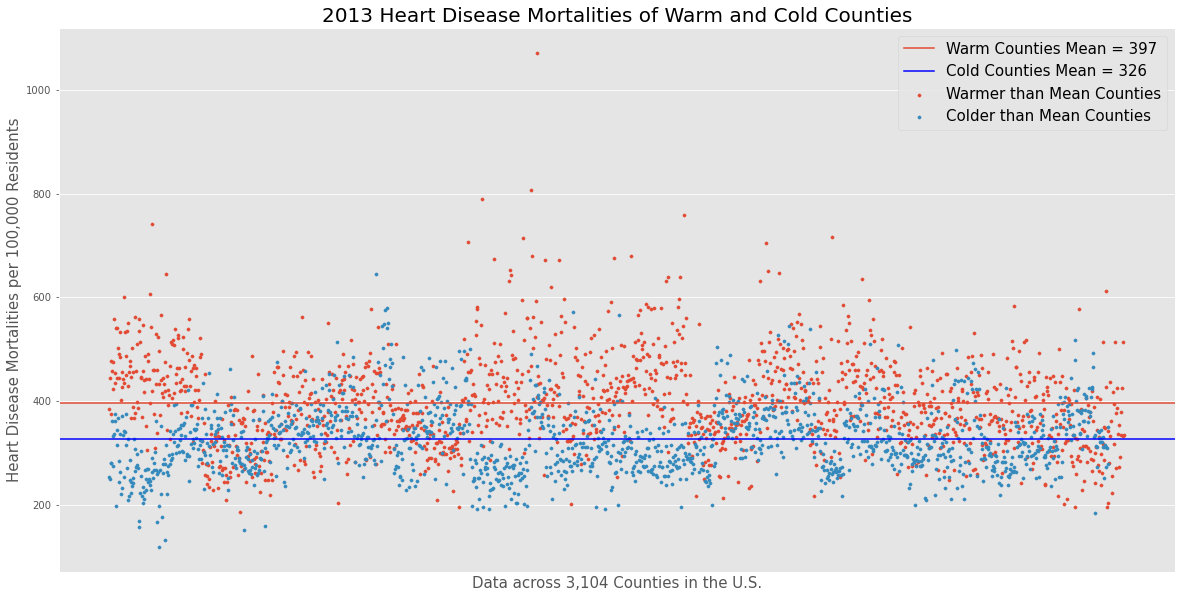

In [109]:
hot_counties = data_set[data_set['2013_average_temp'] > data_set['2013_average_temp'].mean()] 
cold_counties = data_set[data_set['2013_average_temp'] < data_set['2013_average_temp'].mean()] 
hot_mean = hot_counties['2013_mort_per_100k'].mean()
cold_mean= cold_counties['2013_mort_per_100k'].mean()
fig, ax = plt.subplots(figsize=(20, 10))
x1 = list(range(hot_counties.shape[0]))
ax.scatter(x1, hot_counties['2013_mort_per_100k'], s=10, label='Warmer than Mean Counties')

x2 = list(range(cold_counties.shape[0]))
ax.scatter(x2, cold_counties['2013_mort_per_100k'], s=10, label='Colder than Mean Counties')
ax.axhline(hot_counties['2013_mort_per_100k'].mean(), label=f'Warm Counties Mean = {int(hot_mean)}')
ax.axhline(cold_counties['2013_mort_per_100k'].mean(), c='blue', label=f'Cold Counties Mean = {int(cold_mean)}')
ax.set_title('2013 Heart Disease Mortalities of Warm and Cold Counties', size=20)
ax.legend(prop={'size': 15})
ax.set_xticks([])
ax.set_xlabel('Data across 3,104 Counties in the U.S.', size=15)
ax.set_ylabel('Heart Disease Mortalities per 100,000 Residents', size=15)
plt.savefig('../images/warm_cold_scatter.jpg', bbox_inches='tight')

### Let's remove the outlier of Franklin Parish before doing our hypothesis test

In [110]:
hot_counties = hot_counties[hot_counties['2013_mort_per_100k'] != hot_counties['2013_mort_per_100k'].max()]

In [111]:
for i in range(2013, 2019):
    cold_mean = cold_counties[f'{i}_mort_per_100k'].mean()
    hot_mean = hot_counties[f'{i}_mort_per_100k'].mean()
    effect_size = hot_mean - cold_mean
    print(f'{i} Cold counties mean = {round(cold_mean, 2)}, {i} Hot counties mean = {round(hot_mean, 2)}, effect size = {round(effect_size, 2)}')

2013 Cold counties mean = 326.24, 2013 Hot counties mean = 396.57, effect size = 70.33
2014 Cold counties mean = 325.63, 2014 Hot counties mean = 397.48, effect size = 71.84
2015 Cold counties mean = 324.24, 2015 Hot counties mean = 396.55, effect size = 72.31
2016 Cold counties mean = 323.38, 2016 Hot counties mean = 396.3, effect size = 72.92
2017 Cold counties mean = 320.87, 2017 Hot counties mean = 393.52, effect size = 72.65
2018 Cold counties mean = 320.17, 2018 Hot counties mean = 390.39, effect size = 70.23


In [112]:
for year in range(2013, 2019):
    p_val = stats.ttest_ind(hot_counties[f'{year}_mort_per_100k'], cold_counties[f'{year}_mort_per_100k'])[1]
    print(f'{year} P value = {p_val}')


2013 P value = 6.895216481614386e-132
2014 P value = 1.8203897745489114e-132
2015 P value = 1.8605977817616154e-132
2016 P value = 6.417823683673253e-138
2017 P value = 3.127704438021508e-141
2018 P value = 1.525719456537915e-135


In [113]:
income_data = []
for i in range(2013, 2019):
    df = pd.read_csv(f'../data/income/{i}_income.csv', sep=",", engine='python')

    # Cleaning the LocationID column so we can merge with other data set
    df['LocationID'] = df['id'].str[9:]
    df['LocationID'] = df['LocationID'].str.lstrip('0')
    df['LocationID'] = df['LocationID'].astype(str).astype(int)
    df[f'{i}_percentage_less_than_25k'] = ((df.iloc[:, 4] + df.iloc[:, 6] + df.iloc[:, 8]) / df.iloc[:, 2]) * 100
    # Selecting just the columns I want
    df = df.iloc[:,[26, 130, 131]]
    df = df.rename(columns={'Households!!Estimate!!Mean income (dollars)': f'{i}_hh_mean_income',
                           'Estimate!!Households!!Mean income (dollars)': f'{i}_hh_mean_income'})
    income_data.append(df)
    
income_data[0]

,2013_hh_mean_income,LocationID,2013_percentage_less_than_25k
0,64699,1001,0.103632
1,66835,1003,0.032340
2,43926,1005,0.451087
3,48885,1007,0.507686
4,54820,1009,0.125071
...,...,...,...
3216,26009,72145,0.376208
3217,22008,72147,2.362657
3218,24221,72149,0.825770
3219,22984,72151,0.534934


In [114]:
for df in income_data:
    data_set = pd.merge(data_set, df, on='LocationID', how='inner')

data_set.shape

(3104, 48)

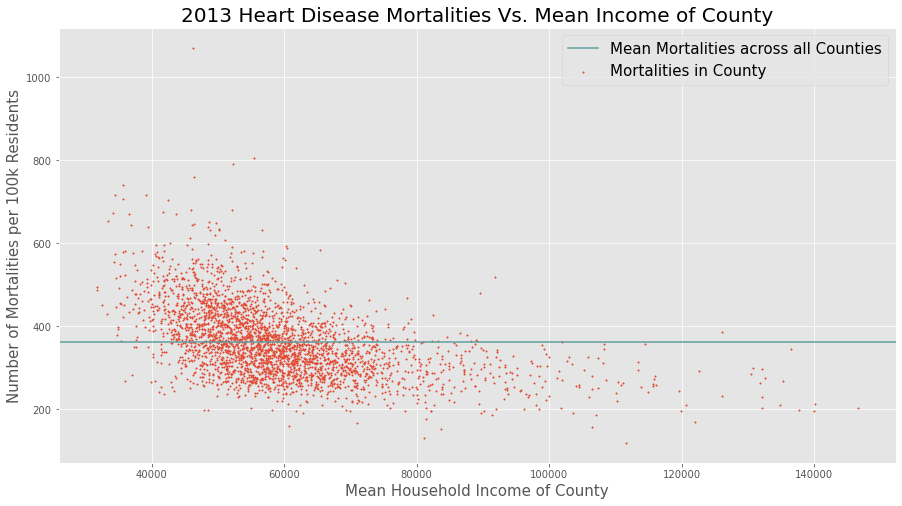

In [116]:
sorted_by_income = data_set.sort_values('2013_hh_mean_income')
fig, ax = plt.subplots(figsize=(15, 8))

ax.scatter(sorted_by_income['2013_hh_mean_income'], sorted_by_income['2013_mort_per_100k'], s=2, 
            label='Mortalities in County')
ax.axhline(sorted_by_income['2013_mort_per_100k'].mean(), label='Mean Mortalities across all Counties', c='cadetblue')
ax.set_xlabel('Mean Household Income of County', size=15)
ax.set_ylabel('Number of Mortalities per 100k Residents', size=15)
ax.set_title('2013 Heart Disease Mortalities Vs. Mean Income of County', size=20)
ax.legend(prop={'size': 15})
plt.savefig('../images/mort_income.jpg', bbox_inches='tight')


<BarContainer object of 1 artists>

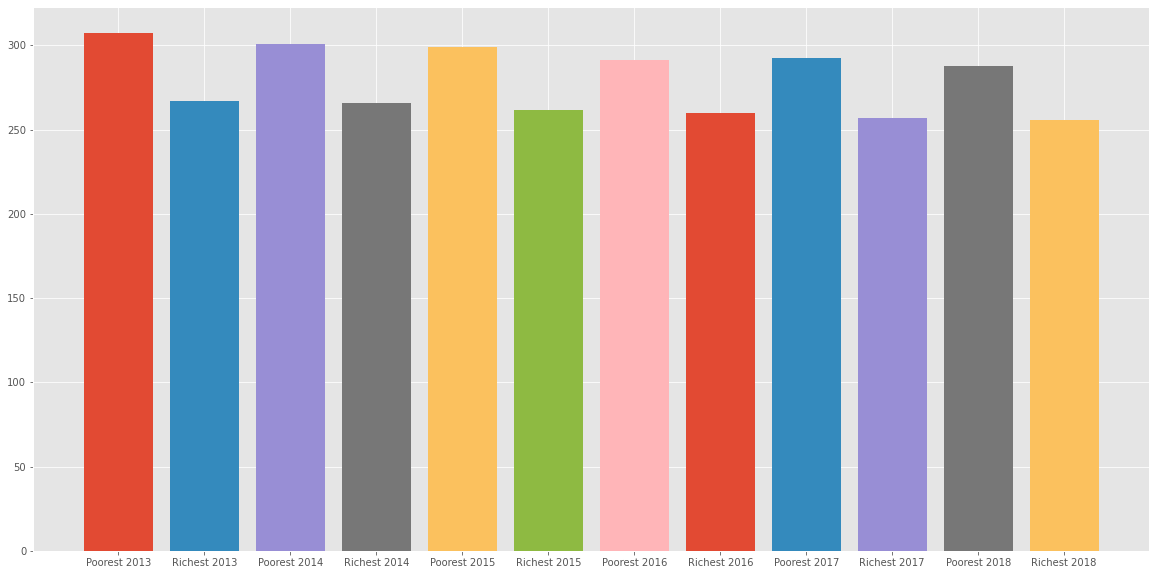

In [77]:
poorest_counties = sorted_by_income.iloc[:100]
richest_counties = sorted_by_income.iloc[-100:]
fig, ax = plt.subplots(figsize=(20, 10))

ax.bar('Poorest 2013', poorest_counties['2013_mort_per_100k'].mean())
ax.bar('Richest 2013', richest_counties['2013_mort_per_100k'].mean())
ax.bar('Poorest 2014', poorest_counties['2014_mort_per_100k'].mean())
ax.bar('Richest 2014', richest_counties['2014_mort_per_100k'].mean())
ax.bar('Poorest 2015', poorest_counties['2015_mort_per_100k'].mean())
ax.bar('Richest 2015', richest_counties['2015_mort_per_100k'].mean())
ax.bar('Poorest 2016', poorest_counties['2016_mort_per_100k'].mean())
ax.bar('Richest 2016', richest_counties['2016_mort_per_100k'].mean())
ax.bar('Poorest 2017', poorest_counties['2017_mort_per_100k'].mean())
ax.bar('Richest 2017', richest_counties['2017_mort_per_100k'].mean())
ax.bar('Poorest 2018', poorest_counties['2018_mort_per_100k'].mean())
ax.bar('Richest 2018', richest_counties['2018_mort_per_100k'].mean())


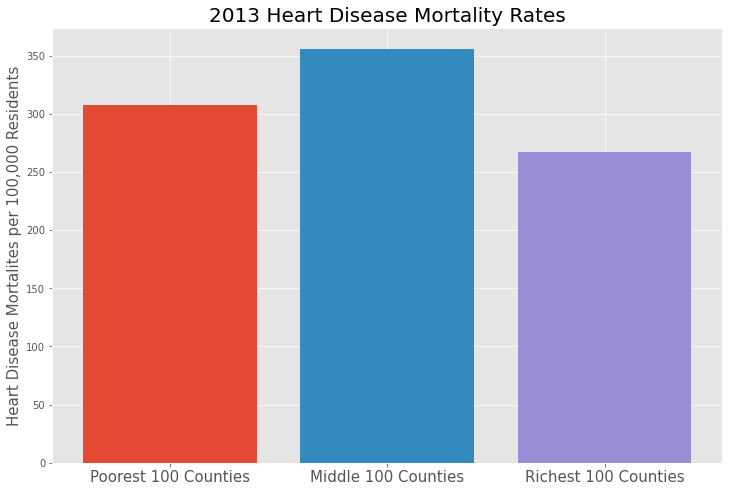

In [78]:
poorest_counties = sorted_by_income.iloc[:100]
middle_counties = sorted_by_income.iloc[1502:1602]
richest_counties = sorted_by_income.iloc[-100:]
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar('Poorest 100 Counties', poorest_counties['2013_mort_per_100k'].mean())
ax.bar('Middle 100 Counties', middle_counties['2013_mort_per_100k'].mean())
ax.bar('Richest 100 Counties', richest_counties['2013_mort_per_100k'].mean())
ax.set_title('2013 Heart Disease Mortality Rates', size=20)
ax.set_ylabel('Heart Disease Mortalites per 100,000 Residents', size=15)
ax.tick_params(axis='x', labelsize=15)
plt.savefig('../images/poor_mid_rich.jpg', bbox_inches='tight')


### Let's divide the counties based on income and then remove Franklin Parish before we perform our t-test

In [120]:
poorest_counties = sorted_by_income[sorted_by_income['2013_hh_mean_income'] < sorted_by_income['2013_hh_mean_income'].mean()]
richest_counties = sorted_by_income[sorted_by_income['2013_hh_mean_income'] > sorted_by_income['2013_hh_mean_income'].mean()]
poorest_counties = poorest_counties[poorest_counties['2013_mort_per_100k'] != poorest_counties['2013_mort_per_100k'].max()]


In [121]:
for i in range(2013, 2019):
    poor_mean = poorest_counties[f'{i}_mort_per_100k'].mean()
    rich_mean = richest_counties[f'{i}_mort_per_100k'].mean()
    effect_size = poor_mean - rich_mean
    print(f'{i} Poor counties mean = {round(poor_mean, 2)}, {i} Rich counties mean = {round(rich_mean, 2)}, effect size = {round(effect_size, 2)}')

2013 Poor counties mean = 391.53, 2013 Rich counties mean = 318.91, effect size = 72.62
2014 Poor counties mean = 392.58, 2014 Rich counties mean = 317.78, effect size = 74.81
2015 Poor counties mean = 391.96, 2015 Rich counties mean = 315.86, effect size = 76.1
2016 Poor counties mean = 390.53, 2016 Rich counties mean = 316.54, effect size = 73.99
2017 Poor counties mean = 387.16, 2017 Rich counties mean = 314.95, effect size = 72.21
2018 Poor counties mean = 384.29, 2018 Rich counties mean = 314.37, effect size = 69.92


In [122]:
for year in range(2013, 2019):
    p_val = stats.ttest_ind(poorest_counties[f'{year}_mort_per_100k'], richest_counties[f'{year}_mort_per_100k'])[1]
    print(f'{year} P value = {p_val}')

2013 P value = 1.4441100963186858e-136
2014 P value = 1.012056987741432e-139
2015 P value = 5.263226873228497e-143
2016 P value = 1.7175694718138132e-137
2017 P value = 1.4324960798497506e-134
2018 P value = 1.168319340702439e-129
